In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ipyleaflet import *

In [7]:
method       = 'hourly'
dataPath     = "/home/guilherme/Documents/GIT - REPOSITORIES/dataset/EnvironmentCanada/Quebec/"+method+"/2018 - Jun2Aug/"
metaDataName = "stations_inventory.csv"

# Environment Canada Weather Information

## Province of Quebec Information

In this section, it's computed relevant information about the hourly data from the Province of Quebec. In order to begin our analysis, let us focus our attention on a short space of time. Therefore, we are going to be interested in the period between June 1st and August 31st. Here, we are just concern about Air Temperature. So, most treatments done here are concern about it as well.

In [8]:
#It opens the metadata and selects the Ids of the Province of Quebec with hourly data at least untill 2018.
metaData = pd.read_csv(metaDataName)
quebecStations = metaData[(metaData["Province"] == "QUEBEC") & (metaData["HLY Last Year"] >= 2018)]
IDs = quebecStations["Station ID"].unique()

In [9]:
dataSet = dict()

#It opens them
for ID in IDs:
    data = pd.read_csv(dataPath+str(ID)+'.csv')
    data = data.dropna(axis = 0, how = 'all')
    dataSet[str(ID)] = data

### Missing Data

Missing data is one of the most relevant information we must know about the data. As it was mentioned above, we are concern about Air Temperature, Relative Humidity, and Dew Point Temperature. So, here it's computed how many stations don't have these measurements in the period of interest.

In [10]:
#It computes how many relevant data are missing on the dataset
countTemp = countRH = countDP   = 0
missingData = pd.DataFrame([], columns = ['Station ID', 'Station Name', 'Has Temp', 'lat', 'lng'])
missingData['Station ID']   = (quebecStations['Station ID'].values).astype('str')
missingData['Station Name'] = quebecStations['Name'].values
missingData['lat']          = np.asarray(quebecStations['Latitude (Decimal Degrees)'].values)
missingData['lng']          = np.asarray(quebecStations['Longitude (Decimal Degrees)'].values)
for key in dataSet:
    data = dataSet[key]
    
    noTmp = data['Temp (°C)'].isna().all()
    countTemp += int(noTmp)
    missingData.loc[missingData['Station ID'] == key,'Has Temp'] = not noTmp

### All Stations Available in 2018

In [11]:
from IPython.display import display, HTML
display(HTML(missingData.to_html()))

,Station ID,Station Name,Has Temp,lat,lng
0,27803,BEAUPORT,False,46.84,-71.20
1,27325,DESCHAMBAULT,True,46.69,-71.97
2,8989,ILE D'ORLEANS,False,47.00,-70.81
3,5237,L'ASSOMPTION,True,45.81,-73.43
4,10871,L'ETAPE,True,47.56,-71.23
5,51457,QUEBEC INTL A,True,46.79,-71.39
6,27646,SHAWINIGAN,True,46.56,-72.73
7,51698,TROIS RIVIERES A,True,46.35,-72.68
8,10764,TROIS-RIVIERES,True,46.35,-72.52
9,8321,TROIS-RIVIERES,True,46.37,-72.68


In [12]:
def countData(dataFrame, dictionary, column, dataQuantity, measName=''):
    '''
    Description: It calculate the pecentage of data available  
    '''
    dataSet = dictionary.copy()
    newdf = dataFrame.copy()
    pct = list()
    for station in dataSet:
        data = dataSet[station]
        pct.append(round(100*data[column].count()/dataQuantity,2))
        
    newdf[measName+" Available Data"+' (%)'] = pct
    return newdf

In [13]:
def fltrbyDQ(dictionary, column, dataQuantity, threshold = 0.6):
    '''
    Description: Filter by Data Quantity. It returns a list with keys that don't have enough data according to the threshold passed.
    '''
    dataSet = dictionary.copy()
    statList = list()
    for station in dataSet:
        data = dataSet[station]
        if data[column].count()/dataQuantity < threshold:
            statList.append(station)
    return statList

In [14]:
def removeItems(dictionary, keys):
    '''
    Description: Remove a list of keys from a dict object.
    '''
    d = dictionary.copy()
    for key in keys:
        d.pop(key)
    return d

In [15]:
dataLength = len(dataSet)
print('Missing Data in %d stations:' %dataLength)
print('Air Temperature:     %.2f'  %(100*countTemp/dataLength) + '%')

Missing Data in 159 stations:
Air Temperature:     11.32%


### Stations that have hourly data from 06/01/2018 to 31/08/2018

In [16]:
availableStations = missingData[(missingData['Has Temp'] == True)]
availableStations.sort_index(axis='index')
availableStations = availableStations.reset_index(drop=True)
availableStations = availableStations[['Station ID', 'Station Name', 'lat', 'lng']]

In [17]:
# clean up dataSet, remainning just the stations that  
avs    = availableStations['Station ID'].values
nodata = np.setdiff1d(missingData['Station ID'].values, avs)
dataSet = removeItems(dataSet, nodata)

In [18]:
from datetime import date

delta = date(2018, 8, 31) - date(2018, 6, 1)
removeList = fltrbyDQ(dataSet, 'Temp (°C)', (delta.days + 1)*24, threshold=0.9)
t90 = removeItems(dataSet,removeList)

In [19]:
availableStations = countData(availableStations, dataSet, 'Temp (°C)', (delta.days + 1)*24, 'Air Temp')
display(HTML(availableStations.to_html()))

,Station ID,Station Name,lat,lng,Air Temp Available Data (%)
0,27325,DESCHAMBAULT,46.69,-71.97,99.95
1,5237,L'ASSOMPTION,45.81,-73.43,100.00
2,10871,L'ETAPE,47.56,-71.23,96.65
3,51457,QUEBEC INTL A,46.79,-71.39,99.91
4,27646,SHAWINIGAN,46.56,-72.73,99.95
5,51698,TROIS RIVIERES A,46.35,-72.68,92.75
6,10764,TROIS-RIVIERES,46.35,-72.52,99.91
7,8321,TROIS-RIVIERES,46.37,-72.68,99.64
8,29452,VALCARTIER A,46.90,-71.50,98.51
9,5293,VALCARTIER A,46.90,-71.50,28.99


In [20]:
print("%.2f" %(100*len(t90)/len(dataSet))+"%", end = ' ') 
print("of the Stations that provide hourly information has at least 90% of the Temperature information")

83.69% of the Stations that provide hourly information has at least 90% of the Temperature information


### Stations Map

In [21]:
from ipywidgets import HTML

m = Map(center=(53.402689, -70.424010), scroll_wheel_zoom = True,  zoom=4, basemap=basemaps.Esri.WorldStreetMap)
markers = list()
for index, row in availableStations.iterrows():
    location = (row['lat'],row['lng'])
    marker = Marker(location=location, draggable = False)
    msg = HTML()
    msg.value = 'Station: %s; ID: %s; Available Data of Temp: %.2f' %(row['Station Name'],
                                                                    row['Station ID'],
                                                                    row['Air Temp Available Data (%)']) + '%; '
    
    marker.popup = msg
    markers.append(marker)
    
marker_cluster = MarkerCluster(markers=markers)
m.add_layer(marker_cluster)

In [40]:
# mouse interaction handling

from ipywidgets import Label

label = Label()

def handle_interaction(**kwargs):
    if kwargs.get('type') == 'mousemove':
        label.value = str(kwargs.get('coordinates'))

**Here, we have a map with all stations available.**

In [41]:
m.on_interaction(handle_interaction)
display(m)
display(label)

Map(center=[51.57706953722567, -90.41039136698244], controls=(ZoomControl(options=['position', 'zoom_in_text',…

Label(value='')

In [24]:
from ipywidgets import HTML

stations90 = availableStations[(availableStations['Air Temp Available Data (%)'] >= 90)]

m2 = Map(center=(53.402689, -70.424010), scroll_wheel_zoom = True,  zoom=4, basemap=basemaps.Esri.WorldStreetMap)
markers = list()
for index, row in stations90.iterrows():
    location = (row['lat'],row['lng'])
    marker = Marker(location=location, draggable = False)
    msg = HTML()
    msg.value = 'Station: %s; ID: %s; Data Available of Temp: %.2f' %(row['Station Name'],
                                                                    row['Station ID'],
                                                                    row['Air Temp Available Data (%)']) + '%; '
    marker.popup = msg
    markers.append(marker)
    
marker_cluster = MarkerCluster(markers=markers)
m2.add_layer(marker_cluster)

In [25]:
# mouse interaction handling

from ipywidgets import Label

label2 = Label()

def handle_interaction(**kwargs):
    if kwargs.get('type') == 'mousemove':
        label2.value = str(kwargs.get('coordinates'))

**Here, we have a map with all stations available that have at least 90% of the hourly data.**

In [26]:
m2.on_interaction(handle_interaction)
display(m2)
display(label2)

Map(center=[53.402689, -70.42401], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title',…

Label(value='')

### Temperature Histogram and Boxplot

In [27]:
tmp = np.asarray([dataSet[key]['Temp (°C)'].values for key in dataSet]).flatten()
tmp = tmp[~np.isnan(tmp)]

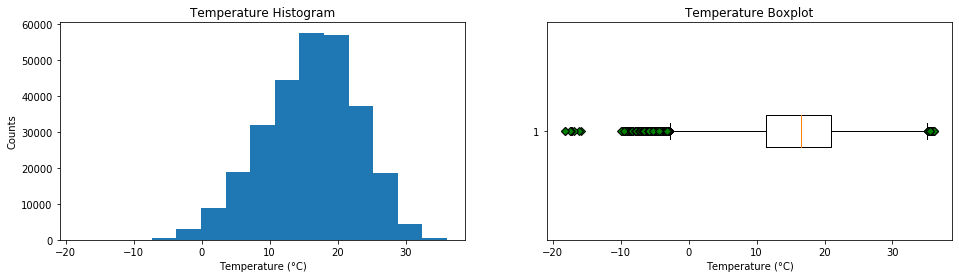

In [28]:
green_diamond = dict(markerfacecolor='g', marker='D')

fig, ax = plt.subplots(1, 2, figsize =(16,4))

ax[0].set_title('Temperature Histogram')
ax[0].hist(tmp, bins=15)
ax[0].set(xlabel='Temperature (°C)', ylabel='Counts')

ax[1].set_title('Temperature Boxplot')
ax[1].boxplot(tmp, vert = False, flierprops=green_diamond)
_ = ax[1].set(xlabel='Temperature (°C)')

### Relative Humidity Histogram and Boxplot

In [29]:
rh = np.asarray([dataSet[key]['Rel Hum (%)'].values for key in dataSet]).flatten()
rh = rh[~np.isnan(rh)]

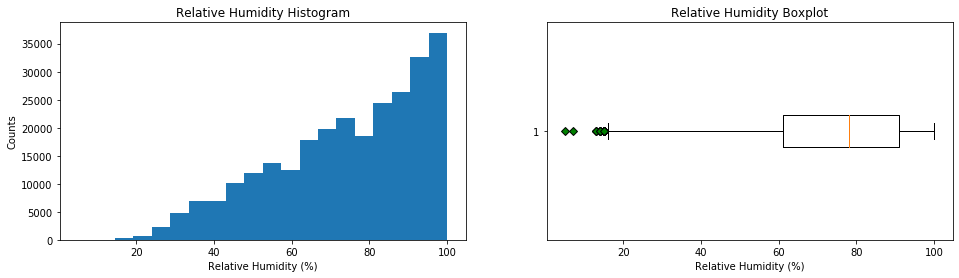

In [30]:
green_diamond = dict(markerfacecolor='g', marker='D')

fig, ax = plt.subplots(1, 2, figsize =(16,4))

ax[0].set_title('Relative Humidity Histogram')
ax[0].hist(rh, bins=20)
ax[0].set(xlabel='Relative Humidity (%)', ylabel='Counts')

ax[1].set_title('Relative Humidity Boxplot')
ax[1].boxplot(rh, vert = False, flierprops=green_diamond)
_ = ax[1].set(xlabel='Relative Humidity (%)')

### Stations Clusters

In [31]:
from sklearn.cluster import KMeans
import numpy as np

X = stations90[['lat', 'lng']].values
kmeans = KMeans(n_clusters=9, random_state=42, n_init=1000, n_jobs = 4, max_iter=1000, precompute_distances=True).fit(X)

In [32]:
import warnings

warnings.filterwarnings(action='ignore')
stations90['Cluster Label'] = kmeans.labels_
warnings.filterwarnings(action='default')

stations90 = stations90[['Station ID', 'Station Name', 'lat','lng','Cluster Label']]
stations90.index = range(stations90.shape[0])
stations90.rename(columns={'lat':'Latitude', 'lng':'Longitude'}, inplace=True)

display(HTML(stations90.to_html()))

HTML(value='<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th></…

In [33]:
from ipywidgets import HTML

colors = ['red', 'black', 'blue', 'yellow', 'green', 'purple', 'gray', 'orange', 'magenta']
coor = stations90[['Latitude','Longitude']].values
name = stations90['Station Name'].values
label = stations90['Cluster Label'].values


m3 = Map(center=(53.402689, -70.424010), scroll_wheel_zoom = True,  zoom=4, basemap=basemaps.Esri.WorldStreetMap)
for i in range(len(label)):
    circle_marker = CircleMarker()
    circle_marker.location = (coor[i][0],coor[i][1])
    circle_marker.radius = 10
    circle_marker.color = colors[label[i]]
    circle_marker.fill_color = colors[label[i]]

    
    marker = Marker(location=(coor[i][0],coor[i][1]), draggable = False)
    msg = HTML()
    msg.value = 'Station: %s; Cluster: %d' %(name[i], label[i])
    marker.popup = msg
    m3.add_layer(marker)
    m3.add_layer(circle_marker)

In [34]:
# mouse interaction handling

from ipywidgets import Label

label3 = Label()

def handle_interaction(**kwargs):
    if kwargs.get('type') == 'mousemove':
        label3.value = str(kwargs.get('coordinates'))

In [35]:
m3.on_interaction(handle_interaction)
display(m3)
display(label3)

Map(center=[53.402689, -70.42401], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title',…

Label(value='')

In [36]:
from datetime import date

delta = date(2018, 8, 31) - date(2018, 6, 1)
removeList = fltrbyDQ(dataSet, 'Temp (°C)', (delta.days + 1)*24, threshold=0.9)
dataSet90 = removeItems(dataSet,removeList)

for key in dataSet90:
    dataSet90[key]['Temp (°C)'] = dataSet90[key]['Temp (°C)'].interpolate(method='nearest', fill_value='extrapolate')
    dataSet90[key] = dataSet90[key][['Date/Time','Station Name','Temp (°C)','Latitude (y)','Longitude (x)']]

In [37]:
clustersSet = dict()

for label in stations90['Cluster Label'].unique():
    s = stations90[stations90['Cluster Label'] == label]
    stations = s['Station ID'].values.astype('str')
    
    dataList = list()
    for ID in stations:
        dataList.append(dataSet90[ID].copy())
    
    total = len(dataList)
    for i in range(1,len(dataList)):
        dataList[0]['Temp (°C)'] = dataList[0]['Temp (°C)'].add(dataList[i]['Temp (°C)'])
    dataList[0]['Temp (°C)'] = dataList[0]['Temp (°C)']/total
        
    clustersSet[str(label)] = dataList[0]

# Stations of Interest

In [38]:
method       = 'daily'
dataPath     = "../dataset/EnvironmentCanada/QuebecStations/"+method+"/2018 - Jun2Aug/"

#It opens the metadata and selects the Ids from the Province of Quebec.
metaData = pd.read_csv("stations_inventory.csv")
quebecStations = metaData[(metaData["Province"] == "QUEBEC") & (metaData["DLY Last Year"] >= 2018)]

f = open('WEATHER_STATIONS.txt', 'r')
s = f.readlines()
f.close()
s = [l.replace('\n','') for l in s]

hw_stations = quebecStations[quebecStations['Name'].isin(s)]
IDs = hw_stations['Station ID'].unique()

dataSet = dict()

#It gets the name of each file downloaded previously
stationFiles = hw_stations['Station ID'].unique().astype('str')

from datetime import date

delta = date(2018, 8, 31) - date(2018, 6, 1)

In [39]:
dataSet = dict()

#It gets the name of each file downloaded previously
stationFiles = hw_stations['Station ID'].unique().astype('str')

#It opens them
for file in stationFiles:
    data = pd.read_csv(dataPath+file+'.csv')
    data = data.dropna(axis = 0, how = 'all')
    dataSet[file] = data

FileNotFoundError: [Errno 2] File ../dataset/EnvironmentCanada/QuebecStations/daily/2018 - Jun2Aug/27803.csv does not exist: '../dataset/EnvironmentCanada/QuebecStations/daily/2018 - Jun2Aug/27803.csv'

## Daily Data

In [ ]:
hw_stations = countData(hw_stations, dataSet, 'Max Temp (°C)', (delta.days + 1), 'Max Temp')
hw_stations = countData(hw_stations, dataSet, 'Min Temp (°C)', (delta.days + 1), 'Min Temp')
hw_stations = hw_stations[['Name', 'Station ID', 'Latitude (Decimal Degrees)',
                           'Longitude (Decimal Degrees)', 'Max Temp Available Data (%)', 'Min Temp Available Data (%)']]
hw_stations.index = range(1,hw_stations.shape[0]+1)
hw_stations

In [ ]:
method       = 'hourly'
dataPath     = "../dataset/EnvironmentCanada/QuebecStations/"+method+"/2018 - Jun2Aug/"

#It opens the metadata and selects the Ids from the Province of Quebec.
metaData = pd.read_csv("stations_inventory.csv")
quebecStations = metaData[(metaData["Province"] == "QUEBEC") & (metaData["HLY Last Year"] >= 2018)]

f = open('WEATHER_STATIONS.txt', 'r')
s = f.readlines()
f.close()
s = [l.replace('\n','') for l in s]

hw_stations = quebecStations[quebecStations['Name'].isin(s)]
IDs = hw_stations['Station ID'].unique()

dataSet = dict()

#It gets the name of each file downloaded previously
stationFiles = hw_stations['Station ID'].unique().astype('str')

from datetime import date

delta = date(2018, 8, 31) - date(2018, 6, 1)

In [ ]:
dataSet = dict()

#It gets the name of each file downloaded previously
stationFiles = hw_stations['Station ID'].unique().astype('str')

#It opens them
for file in stationFiles:
    data = pd.read_csv(dataPath+file+'.csv')
    data = data.dropna(axis = 0, how = 'all')
    dataSet[file] = data

## Hourly Data

In [ ]:
hw_stations = countData(hw_stations, dataSet, 'Temp (°C)', (delta.days + 1)*24, 'Temp')
hw_stations = hw_stations[['Name', 'Station ID', 'Latitude (Decimal Degrees)',
                           'Longitude (Decimal Degrees)', 'Temp Available Data (%)']]
hw_stations.index = range(1,hw_stations.shape[0]+1)
hw_stations

Observing our available data, we can conclude that the only region we can not obtain good information is BEAUPORT. In order to overpass this complication, we chose to extract the information that we need from a station next to BEAUPORT. The closest station to BEAUPORT with good information in the period of interest is STE-FOY (U. LAVAL) (ID: 27377). So, filtering the worst stations and replacing BEAUPORT by STE-FOY (U. LAVAL) we obtain the following stations.

In [ ]:
s[0] = 'STE-FOY (U. LAVAL)'
hw_stations = quebecStations[quebecStations['Name'].isin(s)]
IDs = hw_stations['Station ID'].unique()

dataSet = dict()

#It gets the name of each file downloaded previously
stationFiles = hw_stations['Station ID'].unique().astype('str')

In [ ]:
dataSet = dict()

#It gets the name of each file downloaded previously
stationFiles = hw_stations['Station ID'].unique().astype('str')

#It opens them
for file in stationFiles:
    data = pd.read_csv(dataPath+file+'.csv')
    data = data.dropna(axis = 0, how = 'all')
    dataSet[file] = data

In [ ]:
hw_stations = countData(hw_stations, dataSet, 'Temp (°C)', (delta.days + 1)*24, 'Temp')
hw_stations = hw_stations[['Name', 'Station ID', 'Latitude (Decimal Degrees)',
                           'Longitude (Decimal Degrees)', 'Temp Available Data (%)']]
hw_stations.index = range(1,hw_stations.shape[0]+1)
hr_stations = hw_stations[hw_stations['Temp Available Data (%)'] >= 80]
hr_stations.index = range(1,hr_stations.shape[0]+1)
hr_stations

In [ ]:
# get Julian Day
def getJulianDay(dt, dateCol, yearCol, monthCol, dayCol):
    import datetime as dttm
    
    julianDayCol = "days"
    
    data = dt.copy()
    
    #split datetime into date and time columns
    datetime = np.asarray([d.split(' ') for d in data[dateCol]], dtype='str')
    data[dateCol] = datetime[:,0]
    
    # get year month and day from Date
    date = np.asarray([d.split('-') for d in data[dateCol].values], dtype='uint16')
    
    # create new coluns
    data[yearCol]  = date[:,0]
    data[monthCol] = date[:,1]
    data[dayCol]   = date[:,2]
    data[julianDayCol] = 0
    
    for date in data[dateCol].unique():
        d = dttm.datetime.strptime(date, "%Y-%m-%d") # get datetime object
        data.loc[ (data[yearCol] == d.year) & (data[monthCol] == d.month) & (data[dayCol] == d.day), julianDayCol] = dttm.date(d.year,d.month,d.day).toordinal()
    
    data[julianDayCol] += 1 - data[julianDayCol].min()
    return data

def getMaxMin(dt, column, daysCol):
    '''
    Description:
        It computes max and min value of the specified column passed for each day. 
        It returns a list with the values for each day.
    Input:
        column: The name of the column of interest.
    Output:
        A list with lists containing max and min value for each day. 
        As the following example:

        returning list := [[max1,min1], [max2,min2], ...,[maxN,minN]]
    '''
    julianDayCol = daysCol 
    data = dt.copy()
    
    data = data.dropna(subset=[column])
    
    mxmn_list = list()
    for day in data[julianDayCol].unique():
        d = data[data[julianDayCol] == day] 
        mxmn_list.append([round(np.max(d[column]),2), round(np.min(d[column]),2)])
    
    cols = [julianDayCol, 'Max ' + column, 'Min ' +  column]

    days = np.asarray(data[julianDayCol].unique()).reshape((-1,1))
    mxmn = np.asarray(mxmn_list)
    
    values = np.concatenate((days, mxmn), axis=1)
    newdf = pd.DataFrame(values, columns = cols)
    newdf['DATE'] = data['Date/Time'].unique()
    newdf['days'] = newdf['days'].astype('uint8')
    return newdf

In [ ]:
# clean up dataSet, remainning just the stations of interest 
avs    = hr_stations['Station ID'].values
nodata = np.setdiff1d(list(dataSet.keys()), avs)
dataSet = removeItems(dataSet, nodata)

In [ ]:
hrDataSet = dict()

for station in dataSet:
    data = dataSet[station]

    data = getJulianDay(data, 'Date/Time', 'Year', 'Month', 'Day')
    newdf = getMaxMin(data, 'Temp (°C)', 'days')
    hrDataSet[station] = newdf

### Max and Min Temperature Available For Hourly Data

In [ ]:
hr_stations = countData(hr_stations, hrDataSet, 'Max Temp (°C)', (delta.days + 1), 'Max Temp')
hr_stations = countData(hr_stations, hrDataSet, 'Min Temp (°C)', (delta.days + 1), 'Min Temp')
hr_stations = hr_stations[['Name', 'Station ID', 'Latitude (Decimal Degrees)',
                           'Longitude (Decimal Degrees)', 'Max Temp Available Data (%)', 'Min Temp Available Data (%)']]
hr_stations.index = range(1,hr_stations.shape[0]+1)
hr_stations

In [ ]:
for i in range(hr_stations.shape[0]):
    print(hr_stations['Station ID'].values[i])